# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import nltk

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
punctuation = set(punctuation)
whitespace_pattern = re.compile(r"\s+")
import emoji


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/19545/ADS509 Text Mining/ADS-509-Module-6/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_list = []
for artist in os.listdir("lyrics"):
    artist_path = os.path.join('lyrics',artist)
    for file in os.listdir(artist_path):
        lyrics = os.path.join('lyrics',artist,file)
        with open(lyrics, 'r') as f:
            song = file.replace('.txt','').split('_')[-1]
            lyrics_file = f.read()
            lyrics_list.append({
                "artist_name": artist,
                "song_title": song,
                "lyrics": lyrics_file
            })

# create pandas dataframe
lyrics_data = pd.DataFrame(lyrics_list)
lyrics_data.tail()

,artist_name,song_title,lyrics
415,robyn,wedancetothebeat114528,"""We Dance To The Beat""\n\n\n\nWe dance to the ..."
416,robyn,wheredidourlovego,"""Where Did Our Love Go""\n\n\n\nThoughts about ..."
417,robyn,whosthatgirl,"""Who's That Girl""\n\n\n\nGood girls are pretty..."
418,robyn,witheveryheartbeat,"""With Every Heartbeat""\n\n\n\nMaybe we could m..."
419,robyn,youvegotthatsomething,"""You've Got That Something""\n\n\n\nLook at me ..."


In [5]:
# Read in the twitter data
cher_path = 'C:/Users/19545/ADS509 Text Mining/ADS-509-Module-6/twitter/cher_followers_data.txt'
robynkonichiwa_path = 'C:/Users/19545/ADS509 Text Mining/ADS-509-Module-6/twitter/robynkonichiwa_followers_data.txt'

#reading in cher data
cher_data = pd.read_csv(cher_path, sep = '\t', error_bad_lines = False)
cher_data['Artist_name'] = 'cher'
first_column = cher_data.pop('Artist_name')
cher_data.insert(0, 'Artist_name', first_column)

#Reading Robynkonichiwa data
robynkonichiwa_data = pd.read_csv(robynkonichiwa_path, sep = '\t', encoding = 'utf-8')
robynkonichiwa_data['Artist_name'] = 'robynkonichiwa'
first_column = robynkonichiwa_data.pop('Artist_name')
robynkonichiwa_data.insert(0, 'Artist_name', first_column)
robynkonichiwa_data.head()

C:\Users\19545\AppData\Local\Temp\ipykernel_27260\4049948151.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cher_data = pd.read_csv(cher_path, sep = '\t', error_bad_lines = False)
b'Skipping line 624: expected 7 fields, saw 12\nSkipping line 17506: expected 7 fields, saw 12\nSkipping line 104621: expected 7 fields, saw 12\n'
b'Skipping line 188924: expected 7 fields, saw 12\n'
b'Skipping line 301600: expected 7 fields, saw 12\n'
b'Skipping line 429936: expected 7 fields, saw 12\nSkipping line 444405: expected 7 fields, saw 12\n'
b'Skipping line 677792: expected 7 fields, saw 12\nSkipping line 773482: expected 7 fields, saw 12\n'
b'Skipping line 818258: expected 7 fields, saw 12\nSkipping line 895225: expected 7 fields, saw 12\n'
b'Skipping line 955213: expected 7 fields, saw 10\nSkipping line 994827: expected 7 fields, saw 12\n'
b'Skipping line 1246039: expected 7 fields, saw 12\n'
b'Ski

,Artist_name,screen_name,name,id,location,followers_count,friends_count,description
0,robynkonichiwa,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,I love chill •Facebook / Instagram / SoundClou...
1,robynkonichiwa,songsfornikola,johnny,1502717352575651840,NaN,6,318,"books, movies, music, nature & TV shows. OG Sw..."
2,robynkonichiwa,thibaud_lola,Thibaud Lola,1502407708246478852,NaN,3,69,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...
3,robynkonichiwa,KyleSew2112,Kyle S 🌹🇬🇧🇺🇦,3423966821,South East London,1258,3444,This Twitter profile is full of sarcasm and ra...
4,robynkonichiwa,MusiFlo,MusiFlo,3324069364,Canada,470,1706,Flora Youssef - Blogger & Founder Posting revi...


In [6]:
df_twitter = pd.concat([cher_data, robynkonichiwa_data])
df_twitter.head()

,Artist_name,screen_name,name,id,location,followers_count,friends_count,description
0,cher,hsmcnp,Country Girl,3.515221e+07,NaN,1302.0,1014.0,NaN
1,cher,horrormomy,Jeny,7.421531e+17,Earth,81.0,514.0,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,anju79990584,anju,1.496463e+18,NaN,13.0,140.0,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,gallionjenna,J,3.366480e+09,NaN,752.0,556.0,csu
4,cher,bcscomm,bcscomm,8.391504e+07,"Washington, DC",888.0,2891.0,Writer @Washinformer @SpelmanCollege alumna #D...


In [7]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

pos_words = pd.read_csv(positive_words_file, skiprows=35,
                        header=None).assign(score=1).rename(columns={0:'word'})
neg_words = pd.read_csv(negative_words_file, encoding = 'ISO-8859-1', skiprows=35, 
                        header=None).assign(score=-1).rename(columns={0:'word'})

tidy_text = pd.read_csv(tidy_text_file, sep='\t')

In [8]:
tidy_text['score'] = np.where(tidy_text['sentiment'] == 'negative', -1, 1)
pos_neg_words = pd.concat((pos_words,neg_words, tidy_text[['word', 'score']]), ignore_index = True)
tidy_text.head()

,word,sentiment,lexicon,score
0,abandon,negative,nrc,-1
1,abandoned,negative,nrc,-1
2,abandonment,negative,nrc,-1
3,abba,positive,nrc,1
4,abduction,negative,nrc,-1


In [9]:
pos_neg_words.head()

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [10]:
#convertting pos neg words to dictionary
word = pos_neg_words['word'].to_list()
score = pos_neg_words['score'].to_list()
pos_neg_dict = dict(zip(word, score))

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [11]:
### sentiment score function
def sentiment_score(words):
    score = 0
    for word in words:
        if word in pos_neg_dict:
            score += pos_neg_dict[word]
    return score/(len(words) or not len(words))
    

In [12]:
#functions to clean text
def remove_punctuation(text, punct_set=punctuation) :
    return("".join([ch for ch in text if ch not in punct_set]))

sw = set([remove_punctuation(w) for w in sw])
def remove_stop(tokens) :
    return([t for t in tokens if t.lower() not in sw])

def tokenize(text) :
    return([t for t in whitespace_pattern.split(text) if t])

def prepare(text, pipeline) :
    tokens = str(text)
    for transform in pipeline :
        tokens = transform(tokens)
    return(tokens)

clean_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

In [13]:
# cleaning lyrics data
lyrics_data['cleaned lyrics'] = lyrics_data['lyrics'].apply(prepare, pipeline = clean_pipeline)

In [14]:
#calculating the number of results words for each text
lyrics_data['total_len'] = lyrics_data['cleaned lyrics'].map(lambda x: len(x))

In [15]:
#calculating the sentiment score
lyrics_data['sentiment_score'] = lyrics_data['cleaned lyrics'].apply(sentiment_score)

In [16]:
lyrics_data.head()

,artist_name,song_title,lyrics,cleaned lyrics,total_len,sentiment_score
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h...",182,0.054945
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa...",137,0.284672
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i...",120,-0.041667
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, know, ...",30,-0.066667
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor...",63,0.174603


In [17]:
#Calculating the artist with the highest sentiment score average.
lyrics_data.groupby(['artist_name'])['sentiment_score'].mean()

artist_name
cher     0.059475
robyn    0.066259
Name: sentiment_score, dtype: float64

In [18]:
#Calculating cher highest and lowest sentiment score for her songs
cher = lyrics_data[lyrics_data['artist_name'] == 'cher']

#highest sentiment for cher
cher[cher['sentiment_score'] == cher['sentiment_score'].max()][['song_title', 'sentiment_score']]

,song_title,sentiment_score
181,mylove,0.54321


In [19]:
#lowest sentiment for cher
cher[cher['sentiment_score'] == cher['sentiment_score'].min()][['song_title', 'sentiment_score']]

,song_title,sentiment_score
16,bangbang,-0.417647


In [20]:
#Calculating cher highest and lowest sentiment score for her songs
robyn = lyrics_data[lyrics_data['artist_name'] == 'robyn']

#highest sentiment for cher
robyn[robyn['sentiment_score'] == robyn['sentiment_score'].max()][['song_title', 'sentiment_score']]

,song_title,sentiment_score
319,babyforgiveme,0.554054


In [21]:
#highest sentiment for cher
robyn[robyn['sentiment_score'] == robyn['sentiment_score'].min()][['song_title', 'sentiment_score']]

,song_title,sentiment_score
342,dontfuckingtellmewhattodo,-0.572327
343,dontfuckingtellmewhattodo114520,-0.572327


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn has the highest sentiment score per song. She averaged 0.066259

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Cher highest sentiment score is 0.54321 for the song My love and lowest sentiment score is -0.417647 for the song Bang Bang

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Robyn highest sentiment score is 0.554054 for the song Baby Forgive Me and lowest sentiment score is -0.572327 for the song Don't Fucking Tell Me What To Do.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




artist_name
cher     AxesSubplot(0.125,0.125;0.775x0.755)
robyn    AxesSubplot(0.125,0.125;0.775x0.755)
Name: sentiment_score, dtype: object

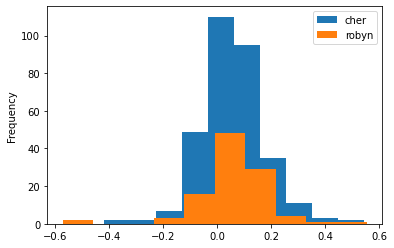

In [22]:
lyrics_data.groupby('artist_name')['sentiment_score'].plot(kind = 'hist', legend = True)

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [23]:
#reading in emoji file
emoji_data = pd.read_csv('C:/Users/19545/ADS509 Text Mining/ADS-509-Module-6/Emoji_Sentiment_Data_v1.0.csv', usecols = ['Emoji', 'Positive', 'Negative'])

In [24]:
emoji_data.head()

,Emoji,Negative,Positive
0,😂,3614,6845
1,❤,355,6361
2,♥,252,4950
3,😍,329,4640
4,😭,2412,1896


In [25]:
emoji_data['sentiment_score'] = emoji_data[['Negative','Positive']].idxmax(axis = 1)
emoji_data.head()

,Emoji,Negative,Positive,sentiment_score
0,😂,3614,6845,Positive
1,❤,355,6361,Positive
2,♥,252,4950,Positive
3,😍,329,4640,Positive
4,😭,2412,1896,Negative


In [26]:
emoji_data['sentiment_score'] = np.where(emoji_data['sentiment_score'] == 'Negative', -1, 1)
emoji_score = emoji_data[['Emoji', 'sentiment_score']]
emoji_score.head()

,Emoji,sentiment_score
0,😂,1
1,❤,1
2,♥,1
3,😍,1
4,😭,-1


In [27]:
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    
    return(len(emojis) > 0)

def emoji_extraction(s):
    return emoji.distinct_emoji_list(s)

In [28]:
word_emoji_score = pd.concat([emoji_score, pos_neg_words], axis = 0)

In [29]:
# convert to dictionary
emoji_word = word_emoji_score['word'].to_list()
score = word_emoji_score['score'].to_list()
emoji_word_dict = dict(zip(emoji_word, score))

In [30]:
# your code here
# cleaning lyrics data
df_twitter['cleaned description'] = df_twitter['description'].apply(prepare, pipeline = clean_pipeline)

In [32]:
#calculating the number of results words for each text
df_twitter['total_len'] = df_twitter['cleaned description'].map(lambda x: len(x))

In [33]:
df_twitter.head()

,Artist_name,screen_name,name,id,location,followers_count,friends_count,description,cleaned description,emoji tokens,total_len
0,cher,hsmcnp,Country Girl,3.515221e+07,NaN,1302.0,1014.0,NaN,[nan],False,1
1,cher,horrormomy,Jeny,7.421531e+17,Earth,81.0,514.0,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",False,6
2,cher,anju79990584,anju,1.496463e+18,NaN,13.0,140.0,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]",False,3
3,cher,gallionjenna,J,3.366480e+09,NaN,752.0,556.0,csu,[csu],False,1
4,cher,bcscomm,bcscomm,8.391504e+07,"Washington, DC",888.0,2891.0,Writer @Washinformer @SpelmanCollege alumna #D...,"[writer, washinformer, spelmancollege, alumna,...",False,17


In [35]:
df_twitter['sentiment_score'] = df_twitter['cleaned description'].apply(sentiment_score)
df = df_twitter[['Artist_name', 'emoji tokens', 'sentiment_score']]

In [37]:
df

,Artist_name,emoji tokens,sentiment_score
0,cher,False,0.000000
1,cher,False,0.000000
2,cher,False,0.000000
3,cher,False,0.000000
4,cher,False,0.176471
...,...,...,...
351834,robynkonichiwa,False,-0.111111
351835,robynkonichiwa,False,0.000000
351836,robynkonichiwa,False,0.000000
351837,robynkonichiwa,False,0.000000


In [38]:
#Calculating the artist with the highest sentiment score average.
df.groupby(['Artist_name'])['sentiment_score'].mean()

Artist_name
cher              0.050025
robynkonichiwa    0.043586
Name: sentiment_score, dtype: float64

Q: What is the average sentiment of your two artists? 

A: The average sentiment for cher is 0.050025 and the average sentiment for robyn is 0.043586

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

